In [1]:
import torch, torchvision
x = torch.rand(5, 3)
print(x)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

tensor([[0.0844, 0.1759, 0.5787],
        [0.3165, 0.5600, 0.1054],
        [0.9363, 0.1875, 0.8008],
        [0.0705, 0.4647, 0.3042],
        [0.1695, 0.1583, 0.0086]])
cuda:0


## Dataset Loading

Before continuing, run `data_loading_structure.py` once to change de TEST folder structure to a subfolder per label type of structure. This is so we can use the default dataloaders of pytorch. 

In [5]:
#Run just once
# !python ./data_loading_structure.py


In [2]:
import os
import pandas as pd
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch

In [37]:
image_size = 56
transform = transforms.Compose(
    [transforms.Resize([image_size, image_size]),
     transforms.TrivialAugmentWide(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]
     )

batch_size = 4

trainset = torchvision.datasets.ImageFolder(root='./traffic_Data/DATA/', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root='./traffic_Data/TEST/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [27]:
from collections import Counter
import numpy as np
class_counts = np.fromiter(dict(Counter(trainset.targets)).values(), dtype=float)
print(class_counts)

[118.  40.  70. 138.  96.  36. 128.  22. 142. 130.   8.   4.  80.  18.
  12.  18.  14. 100.   2. 126.  28. 446.  44. 260. 150.  42.  14.   4.
  26. 156.  40.  58.  30.  34.  98.  32.  18.  32.  82.  30.  24.  18.
  12.  10.  42. 194.  56.   8.  36.   2. 324. 162. 110.   6.  78. 152.
   8.   2.]


Labels

In [24]:

labels_df = pd.read_csv('./labels.csv')
lables_csv = labels_df.iloc[:,0].to_list()
classes = labels_df.iloc[:,1].to_list()
print(classes)

['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Speed limit (30km/h)', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'speed limit (80km/h)', 'Dont Go straight or left', 'Dont Go straight or Right', 'Dont Go straight', 'Dont Go Left', 'Dont Go Left or Right', 'Dont Go Right', 'Dont overtake from Left', 'No Uturn', 'No Car', 'No horn', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Go straight or right', 'Go straight', 'Go Left', 'Go Left or right', 'Go Right', 'keep Left', 'keep Right', 'Roundabout mandatory', 'watch out for cars', 'Horn', 'Bicycles crossing', 'Uturn', 'Road Divider', 'Traffic signals', 'Danger Ahead', 'Zebra Crossing', 'Bicycles crossing', 'Children crossing', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Unknown1', 'Unknown2', 'Unknown3', 'Go right or straight', 'Go left or straight', 'Unknown4', 'ZigZag Curve', 'Train Crossing', 'Under Construction', 'Unknown5', 'Fences', 'Heavy Vehicle Accidents'

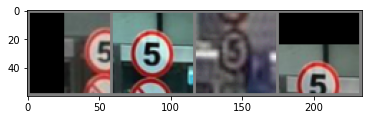

Speed limit (5km/h) Speed limit (5km/h) Speed limit (5km/h) Speed limit (5km/h)


In [38]:
import matplotlib.pyplot as plt
# import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, ex_labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[ex_labels[j]]:5s}' for j in range(batch_size)))

In [91]:
6*(((image_size-5+1)/2)**2)

31974.0

## Convolutional Net

In [57]:

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 11 * 11, 120)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(120, len(classes))
        # int(6*(((image_size-5+1)/2)**2))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1936, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=58, bias=True)
)

In [58]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(1/class_counts).float().to(device))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [59]:
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        # running_loss = 0.0
        if i % 1000 == 999:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 1.563
[2,  1000] loss: 0.992
[3,  1000] loss: 0.741
[4,  1000] loss: 0.617
[5,  1000] loss: 0.531
[6,  1000] loss: 0.482
[7,  1000] loss: 0.422
[8,  1000] loss: 0.406


### Saving Net

In [54]:
PATH = './model'
torch.save(net.state_dict(), PATH)

## Testing

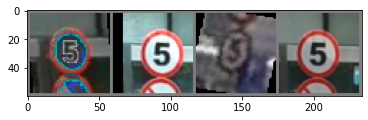

GroundTruth:  Speed limit (5km/h) Speed limit (5km/h) Speed limit (5km/h) Speed limit (5km/h)


In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [55]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Speed limit (5km/h) Speed limit (5km/h) Unknown6 Speed limit (5km/h)


## Accuracy

In [56]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images).to(device)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        # print(f'labels: {labels}')
        # print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 16 %


In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images).to(device)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

Accuracy of the network on the train images: 97 %


In [55]:
import torch
x = torch.arange(4.0)
x.requires_grad_(True) 
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [63]:
x = torch.zeros((2,3))
print(x)
print(x.shape[0])
print(x.reshape((-1, x.shape[0])))
# print(x)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
2
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
